# Q-learning or Q-network (QN)

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], batch[0][1].shape

([0,
  array([ 0.04948415, -0.17727965,  0.04583192,  0.34480253]),
  1.0,
  False,
  {}],
 (4,))

In [6]:
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.772122185233318 -2.5209229796650017


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
def model_input(state_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return actions, states, targetQs

In [9]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [10]:
def model_loss(actions, states, targetQs, # model input
               action_size, hidden_size): # model init
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
    # loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits, 
    #                                                               labels=tf.nn.sigmoid(Qs_labels)))    
    return actions_logits, loss

In [11]:
def model_opt(loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [12]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [13]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)

state size:(1000, 4) actions:(1000,)
2


In [15]:
# Training parameters
batch_size = 1000              # number of samples in the memory/ experience as mini-batch size
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation

In [16]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [17]:
state = env.reset()
for _ in range(batch_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [18]:
state, reward, action

(array([ 0.10405424,  0.77265722, -0.18982688, -1.51150224]), 1.0, 1)

In [ ]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, loss_list = [], []

# TF session for training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    
    # Training episodes/epochs
    for ep in range(11111):
        state = env.reset()
        total_reward = 0
        loss_batch = []

        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            total_reward += reward
            state = next_state

            # Training
            batch = memory.buffer
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            next_actions_logits = sess.run(model.actions_logits, feed_dict = {model.states: next_states}) 
            nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
            targetQs = rewards + (0.99 * nextQs)
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                     model.actions: actions,
                                                                     model.targetQs: targetQs})
            loss_batch.append(loss)
            if done is True:
                break
                
        episodes_total_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'loss:{:.4f}'.format(np.mean(loss_batch)),
              'explore_p:{:.4f}'.format(explore_p))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        loss_list.append([ep, np.mean(loss_batch)])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-qn.ckpt')

Episode:0 meanR:17.0000 loss:1.3251 explore_p:0.9983
Episode:1 meanR:19.0000 loss:2.2834 explore_p:0.9962
Episode:2 meanR:17.6667 loss:3.4505 explore_p:0.9948
Episode:3 meanR:19.2500 loss:6.1570 explore_p:0.9924
Episode:4 meanR:24.8000 loss:68.7073 explore_p:0.9878
Episode:5 meanR:23.6667 loss:347.5805 explore_p:0.9860
Episode:6 meanR:21.8571 loss:639.1490 explore_p:0.9850
Episode:7 meanR:26.3750 loss:533.3741 explore_p:0.9793
Episode:8 meanR:27.0000 loss:66.7435 explore_p:0.9762
Episode:9 meanR:25.2000 loss:47.1252 explore_p:0.9754
Episode:10 meanR:26.9091 loss:43.7758 explore_p:0.9711
Episode:11 meanR:27.0000 loss:47.4970 explore_p:0.9684
Episode:12 meanR:26.0000 loss:52.2377 explore_p:0.9671
Episode:13 meanR:25.5714 loss:54.6022 explore_p:0.9652
Episode:14 meanR:24.8667 loss:56.9052 explore_p:0.9638
Episode:15 meanR:24.3125 loss:59.8603 explore_p:0.9622
Episode:16 meanR:23.7059 loss:62.7379 explore_p:0.9609
Episode:17 meanR:23.6667 loss:67.8908 explore_p:0.9587
Episode:18 meanR:23.7

Episode:137 meanR:39.9400 loss:427907612672.0000 explore_p:0.6134
Episode:138 meanR:40.4200 loss:535009034240.0000 explore_p:0.6096
Episode:139 meanR:40.7500 loss:573563535360.0000 explore_p:0.6069
Episode:140 meanR:40.9300 loss:602375323648.0000 explore_p:0.6047
Episode:141 meanR:41.3100 loss:511473221632.0000 explore_p:0.6012
Episode:142 meanR:41.6700 loss:589898645504.0000 explore_p:0.5976
Episode:143 meanR:41.8100 loss:626501025792.0000 explore_p:0.5945
Episode:144 meanR:43.4500 loss:549120507904.0000 explore_p:0.5836
Episode:145 meanR:44.0300 loss:603626340352.0000 explore_p:0.5792
Episode:146 meanR:44.8000 loss:385159200768.0000 explore_p:0.5702
Episode:147 meanR:45.4400 loss:234915135488.0000 explore_p:0.5651
Episode:148 meanR:45.1500 loss:197459247104.0000 explore_p:0.5636
Episode:149 meanR:45.4900 loss:179704168448.0000 explore_p:0.5600
Episode:150 meanR:45.0300 loss:166114197504.0000 explore_p:0.5593
Episode:151 meanR:45.4100 loss:140949700608.0000 explore_p:0.5562
Episode:15

Episode:260 meanR:195.9300 loss:9250670641152.0000 explore_p:0.0806
Episode:261 meanR:197.7200 loss:9279679496192.0000 explore_p:0.0793
Episode:262 meanR:199.3600 loss:9284785012736.0000 explore_p:0.0779
Episode:263 meanR:199.1200 loss:9076744388608.0000 explore_p:0.0765
Episode:264 meanR:200.8200 loss:8848535453696.0000 explore_p:0.0753
Episode:265 meanR:201.2300 loss:8941834600448.0000 explore_p:0.0741
Episode:266 meanR:201.3400 loss:8870695010304.0000 explore_p:0.0727
Episode:267 meanR:201.2500 loss:8914982666240.0000 explore_p:0.0716
Episode:268 meanR:200.0300 loss:8957768761344.0000 explore_p:0.0704
Episode:269 meanR:200.7400 loss:8964662099968.0000 explore_p:0.0692
Episode:270 meanR:200.7800 loss:8793369346048.0000 explore_p:0.0680
Episode:271 meanR:200.5000 loss:8907036557312.0000 explore_p:0.0669
Episode:272 meanR:200.9100 loss:8945967038464.0000 explore_p:0.0658
Episode:273 meanR:202.5200 loss:8981446656000.0000 explore_p:0.0648
Episode:274 meanR:202.2300 loss:9076394164224.00

Episode:381 meanR:191.5200 loss:8568905400320.0000 explore_p:0.0169
Episode:382 meanR:191.4100 loss:8862344151040.0000 explore_p:0.0168
Episode:383 meanR:191.3400 loss:8971270225920.0000 explore_p:0.0166
Episode:384 meanR:191.3800 loss:8893848616960.0000 explore_p:0.0165
Episode:385 meanR:191.3200 loss:8934011174912.0000 explore_p:0.0164
Episode:386 meanR:191.0900 loss:9086927110144.0000 explore_p:0.0162
Episode:387 meanR:190.9200 loss:9184946946048.0000 explore_p:0.0161
Episode:388 meanR:190.7900 loss:9223121403904.0000 explore_p:0.0160
Episode:389 meanR:190.8600 loss:9360992370688.0000 explore_p:0.0159
Episode:390 meanR:190.6600 loss:9422147420160.0000 explore_p:0.0158
Episode:391 meanR:190.9400 loss:9282529525760.0000 explore_p:0.0157
Episode:392 meanR:190.9700 loss:9147973107712.0000 explore_p:0.0156
Episode:393 meanR:191.0900 loss:9039466463232.0000 explore_p:0.0155
Episode:394 meanR:191.4500 loss:8834571567104.0000 explore_p:0.0153
Episode:395 meanR:191.3700 loss:8872408383488.00

Episode:502 meanR:191.5100 loss:9318250315776.0000 explore_p:0.0107
Episode:503 meanR:191.3700 loss:9208925782016.0000 explore_p:0.0107
Episode:504 meanR:191.6000 loss:9242964656128.0000 explore_p:0.0107
Episode:505 meanR:191.2600 loss:9412776296448.0000 explore_p:0.0106
Episode:506 meanR:191.1900 loss:9372949282816.0000 explore_p:0.0106
Episode:507 meanR:191.4100 loss:9404943433728.0000 explore_p:0.0106
Episode:508 meanR:191.1700 loss:9546430939136.0000 explore_p:0.0106
Episode:509 meanR:191.1700 loss:9421291782144.0000 explore_p:0.0106
Episode:510 meanR:191.2100 loss:9476172152832.0000 explore_p:0.0106
Episode:511 meanR:191.3400 loss:9367064674304.0000 explore_p:0.0106
Episode:512 meanR:191.5500 loss:9169801314304.0000 explore_p:0.0106
Episode:513 meanR:191.3800 loss:9120174309376.0000 explore_p:0.0106
Episode:514 meanR:191.5500 loss:9034291740672.0000 explore_p:0.0105
Episode:515 meanR:191.5300 loss:8851408551936.0000 explore_p:0.0105
Episode:516 meanR:191.5900 loss:8962824994816.00

Episode:623 meanR:191.2100 loss:9347945988096.0000 explore_p:0.0101
Episode:624 meanR:191.3900 loss:9438707580928.0000 explore_p:0.0101
Episode:625 meanR:191.4200 loss:9348905435136.0000 explore_p:0.0101
Episode:626 meanR:191.4000 loss:9257536716800.0000 explore_p:0.0101
Episode:627 meanR:191.0300 loss:9378786705408.0000 explore_p:0.0101
Episode:628 meanR:190.7600 loss:9397003616256.0000 explore_p:0.0101
Episode:629 meanR:190.6000 loss:9403985035264.0000 explore_p:0.0101
Episode:630 meanR:190.6700 loss:9280436568064.0000 explore_p:0.0101
Episode:631 meanR:190.7500 loss:9220837605376.0000 explore_p:0.0101
Episode:632 meanR:190.7700 loss:9209777225728.0000 explore_p:0.0101
Episode:633 meanR:190.8100 loss:9060213587968.0000 explore_p:0.0101
Episode:634 meanR:190.8500 loss:8956346892288.0000 explore_p:0.0101
Episode:635 meanR:190.8300 loss:9072447324160.0000 explore_p:0.0101
Episode:636 meanR:190.6500 loss:9226313269248.0000 explore_p:0.0101
Episode:637 meanR:190.6900 loss:9230841020416.00

Episode:744 meanR:192.5200 loss:9235405471744.0000 explore_p:0.0100
Episode:745 meanR:192.3900 loss:9231020326912.0000 explore_p:0.0100
Episode:746 meanR:192.4700 loss:9307557986304.0000 explore_p:0.0100
Episode:747 meanR:192.3800 loss:9261077757952.0000 explore_p:0.0100
Episode:748 meanR:192.3800 loss:9241337266176.0000 explore_p:0.0100
Episode:749 meanR:192.5100 loss:9229355188224.0000 explore_p:0.0100
Episode:750 meanR:192.2700 loss:9316388044800.0000 explore_p:0.0100
Episode:751 meanR:192.0600 loss:9425076092928.0000 explore_p:0.0100
Episode:752 meanR:191.8300 loss:9508275355648.0000 explore_p:0.0100
Episode:753 meanR:191.7100 loss:9615061286912.0000 explore_p:0.0100
Episode:754 meanR:191.5600 loss:9585562746880.0000 explore_p:0.0100
Episode:755 meanR:191.3300 loss:9571994173440.0000 explore_p:0.0100
Episode:756 meanR:191.7200 loss:9244619309056.0000 explore_p:0.0100
Episode:757 meanR:191.9200 loss:8926800117760.0000 explore_p:0.0100
Episode:758 meanR:191.8100 loss:8965037490176.00

Episode:865 meanR:190.0400 loss:8984964628480.0000 explore_p:0.0100
Episode:866 meanR:189.9000 loss:9142580281344.0000 explore_p:0.0100
Episode:867 meanR:190.0300 loss:9291082760192.0000 explore_p:0.0100
Episode:868 meanR:190.0900 loss:9328081764352.0000 explore_p:0.0100
Episode:869 meanR:190.2600 loss:9375043289088.0000 explore_p:0.0100
Episode:870 meanR:190.3700 loss:9156319772672.0000 explore_p:0.0100
Episode:871 meanR:190.2000 loss:8907249418240.0000 explore_p:0.0100
Episode:872 meanR:190.1200 loss:8914496126976.0000 explore_p:0.0100
Episode:873 meanR:190.1700 loss:8973989183488.0000 explore_p:0.0100
Episode:874 meanR:190.2300 loss:9072077176832.0000 explore_p:0.0100
Episode:875 meanR:190.1100 loss:9225973530624.0000 explore_p:0.0100
Episode:876 meanR:190.0900 loss:9348546822144.0000 explore_p:0.0100
Episode:877 meanR:189.8500 loss:9429932048384.0000 explore_p:0.0100
Episode:878 meanR:189.5400 loss:9598339645440.0000 explore_p:0.0100
Episode:879 meanR:189.6100 loss:9688663982080.00

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

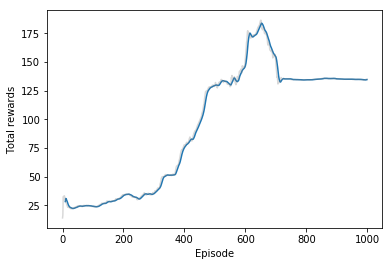

In [28]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

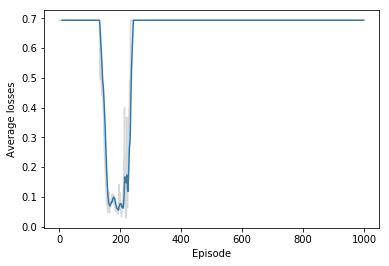

In [48]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [49]:
import gym
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model-qn.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        for _ in range(111111111111111111):
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {:.2f}'.format(total_reward))
        env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model-qn.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.00


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.